# COVID-19 prediction using MLPRegressor

## Data collection (Czech)

1. Download data from various endpoints from API https://onemocneni-aktualne.mzcr.cz/api/v3/docs (you need to ask for API Token)
2. Merge data from various endpoints into 1 CSV with all the information
3. Prepare inputs and outputs for the network to work with

### 1. Downloading data

This was relatively straight-forward since the API has great documentation. Only limitation was 1000 calls/hour limit. Since API has pages of data to not allow too big data transfers, this took hours to download.

API has data more detailed, than we wanted for our training, so we needed to simplify it (for example: people infected in a given day were separated into age groups, but we decided to ignore this and sum them).

Script for downloading is in */czech/download_data.py*

### 2. Merge data

Merge process was relatively simple with *pandas* library. We merged data from different endpoints using date/datum as key.

In this stage we also filled in missing values. Most of them were near the beginning of the pandemic

Script used is in */czech/combine.py*

### 3. Preparing inputs and outputs

Used columns for inputs:
- prirustkovy_pocet_nakazenych
- kumulativni_pocet_nakazenych
- prirustkovy_pocet_vylecenych
- kumulativni_pocet_vylecenych
- prirustkovy_pocet_umrti
- kumulativni_pocet_umrti
- first_vaccine_cumulative
- second_vaccine_cumulative
- currently_sick

Columns used for outputs:
- prirustkovy_pocet_nakazenych
- prirustkovy_pocet_umrti

We used script for generating inputs and outputs in the following fashion:

- script has a flag for normalizing data to interval [0,1] (more seems unneccessary since no column has negative numbers)
- each of the days before has several columns
- days are stored after one another in a vector
- we used default values for --before (10) and --future (2) flags and we also used flag for normalization (-n)
- inputs are stored in */czech/inputs.csv*, outputs in */czech/outputs.csv*


Script used is in */czech/prepare.py*

## Data collection (Slovak)

Slovakia has github repository with all the available data (https://github.com/Institut-Zdravotnych-Analyz/covid19-data). So we downloaded it and went from there.

This repository stores less information than its Czech counterpart, but it will serve well for one of the experiments (How well can NN with fewer attributes predict for unseen data?)

## Training and results (Czech)

First of all, we perform analysis using PCA. It shows that over 90% of input data can be described using 2 attributes (shown below). Even so, during training it was shown that using 20-30 components for PCA yields best results.

We also removed rows/days for which there was 0 value in column "cumulative sick". This greatly improved training.

We used *GridSearchCV* from *scikit-learn* library, but we soon found out that *over training can be a real issue* (higher RMSE), since MLPRegressor with 1_000 iterations and 1_000 hidden neurons yielded worse results than MLPRegressor with only 100 hidden neurons and 1_000 iterations (predictions can be seen in lower section).

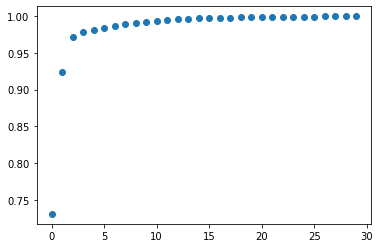

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA

df = pd.read_csv('czech/inputs.csv')
pca = PCA(n_components=30)
pca.fit(df)
ratio = list(pca.explained_variance_ratio_)
#plt.plot([x for x in range(len(pca.explained_variance_ratio_))], ratio, 'o')

cumulative_ratio = list()
cum_sum = 0
for r in ratio:
    cum_sum += r
    cumulative_ratio.append( cum_sum )
#print(cumulative_ratio)
plt.plot([x for x in range(len(pca.explained_variance_ratio_))], cumulative_ratio, 'o')

#_ = plt.ylim(0, 1)

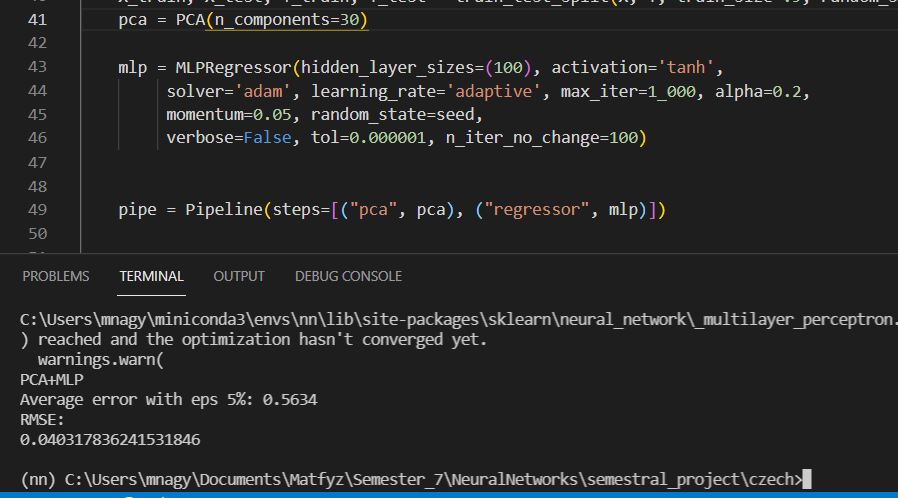

In [2]:
from IPython.display import Image
Image(filename='best_czech_training.png') 

Test size: 64


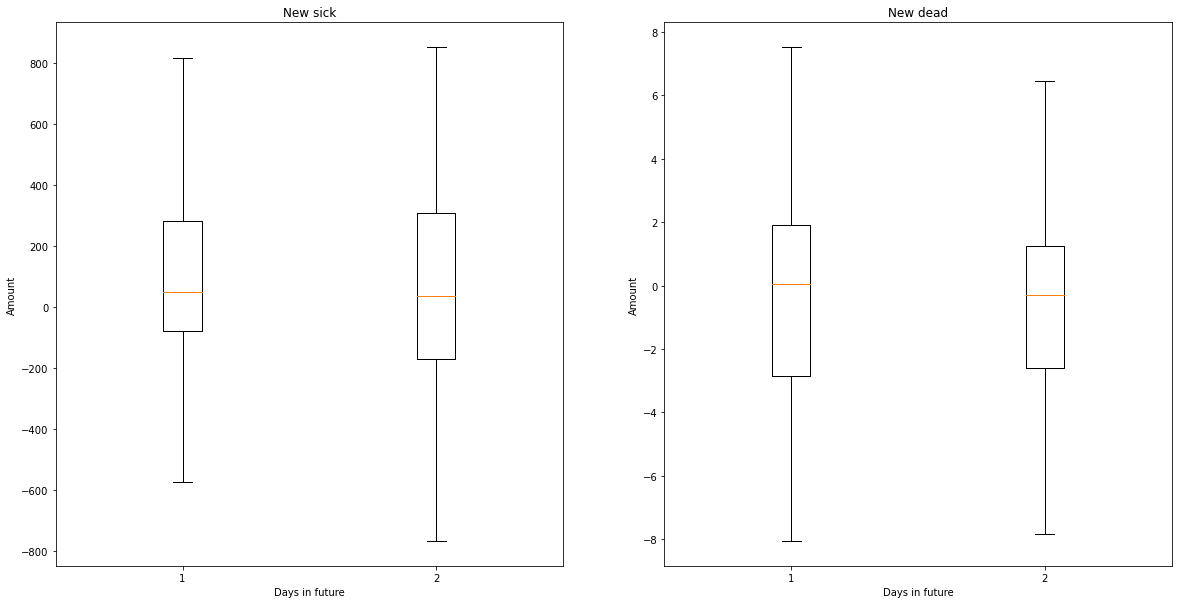

In [4]:
# box plots for predicted results per attribute
import pickle
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

seed = 42
with open('czech/manual_test_model.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

X = pd.read_csv('czech/inputs.csv')
Y = pd.read_csv('czech/outputs.csv')
_, X_test, _, Y_test = train_test_split(X, Y, train_size=.9, random_state=seed)
print(f'Test size: {Y_test.shape[0]}')
Y_pred = model.predict(X_test)

diff = Y_pred - Y_test

# denormalize
import json
with open('czech/outputs_norm_params.json', 'r') as norm_param_file:
    output_norm_params = json.load(norm_param_file)
norm_ps = np.array([ x['p'] for x in output_norm_params ])
norm_qs = np.array([ x['q'] for x in output_norm_params ])

unnormalized = norm_ps * diff.to_numpy() + norm_qs

new_sick = unnormalized[:, [0,2]]
new_dead = unnormalized[:, [1,3]]

figure, axis = plt.subplots(1, 2)
figure.set_figwidth(20)
figure.set_figheight(10)

axis[0].set_title('New sick')
axis[0].set_xlabel('Days in future')
axis[0].set_ylabel('Amount')
_ = axis[0].boxplot(new_sick, notch=False, sym='')

axis[1].set_title('New dead')
axis[1].set_xlabel('Days in future')
axis[1].set_ylabel('Amount')
_ = axis[1].boxplot(new_dead, notch=False, sym='')

{'pca__n_components': 20, 'regressor__activation': 'relu', 'regressor__alpha': 0.005, 'regressor__hidden_layer_sizes': 2000, 'regressor__learning_rate': 'adaptive', 'regressor__max_iter': 100, 'regressor__momentum': 0.2, 'regressor__random_state': 42, 'regressor__solver': 'adam'}
Test size: 64


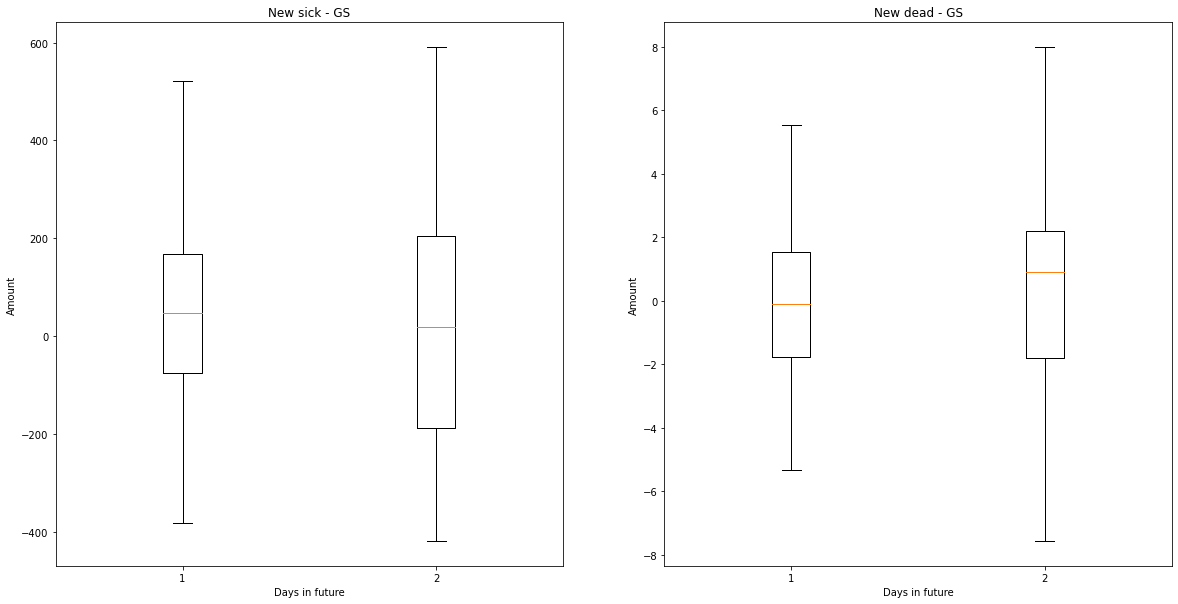

In [3]:
# box plots for predicted results per attribute (GridSeachCV)
import pickle
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

seed = 42
with open('czech/search2.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

print(model.best_params_)

X = pd.read_csv('czech/inputs.csv')
Y = pd.read_csv('czech/outputs.csv')
_, X_test, _, Y_test = train_test_split(X, Y, train_size=.9, random_state=seed)
print(f'Test size: {Y_test.shape[0]}')
Y_pred = model.predict(X_test)

diff = Y_pred - Y_test

# denormalize
import json
with open('czech/outputs_norm_params.json', 'r') as norm_param_file:
    output_norm_params = json.load(norm_param_file)
norm_ps = np.array([ x['p'] for x in output_norm_params ])
norm_qs = np.array([ x['q'] for x in output_norm_params ])

unnormalized = norm_ps * diff.to_numpy() + norm_qs

new_sick = unnormalized[:, [0,2]]
new_dead = unnormalized[:, [1,3]]

figure, axis = plt.subplots(1, 2)
figure.set_figwidth(20)
figure.set_figheight(10)

axis[0].set_title('New sick - GS')
axis[0].set_xlabel('Days in future')
axis[0].set_ylabel('Amount')
_ = axis[0].boxplot(new_sick, notch=False, sym='')

axis[1].set_title('New dead - GS')
axis[1].set_xlabel('Days in future')
axis[1].set_ylabel('Amount')
_ = axis[1].boxplot(new_dead, notch=False, sym='')

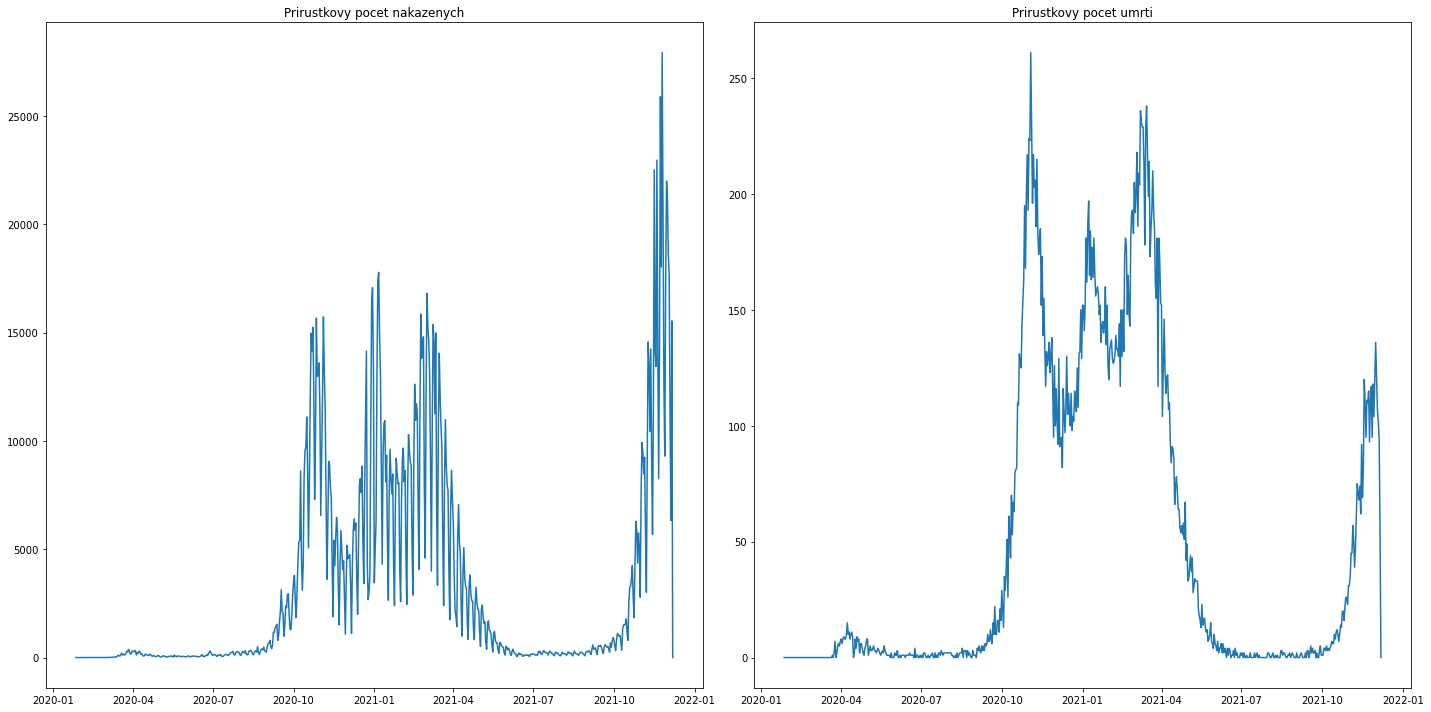

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_csv('czech/combined.csv')
df['datum'] = df['datum'].astype(np.datetime64)
figure, axis = plt.subplots(1, 2)
figure.set_figwidth(20)
figure.set_figheight(10)

axis[0].set_title('Prirustkovy pocet nakazenych')
axis[0].plot(df['datum'], df['prirustkovy_pocet_nakazenych'])

axis[1].set_title('Prirustkovy pocet umrti')
axis[1].plot(df['datum'], df['prirustkovy_pocet_umrti'])

plt.tight_layout()

## Training and results (Slovak)

We proceeded in a similar manner, but since Slovak data has less attributes, we needed to train on less columns.

Training and testing was done on data until December 2nd 2021. After that, we tried to do predictions on data from 2.12.2021 until yesterday. 

The plots show the real data, and the colorful lines are our approximations for the next two days based on the last 10 days. We can see, that the curves are similar, but the predicitons are slightly upscaled.

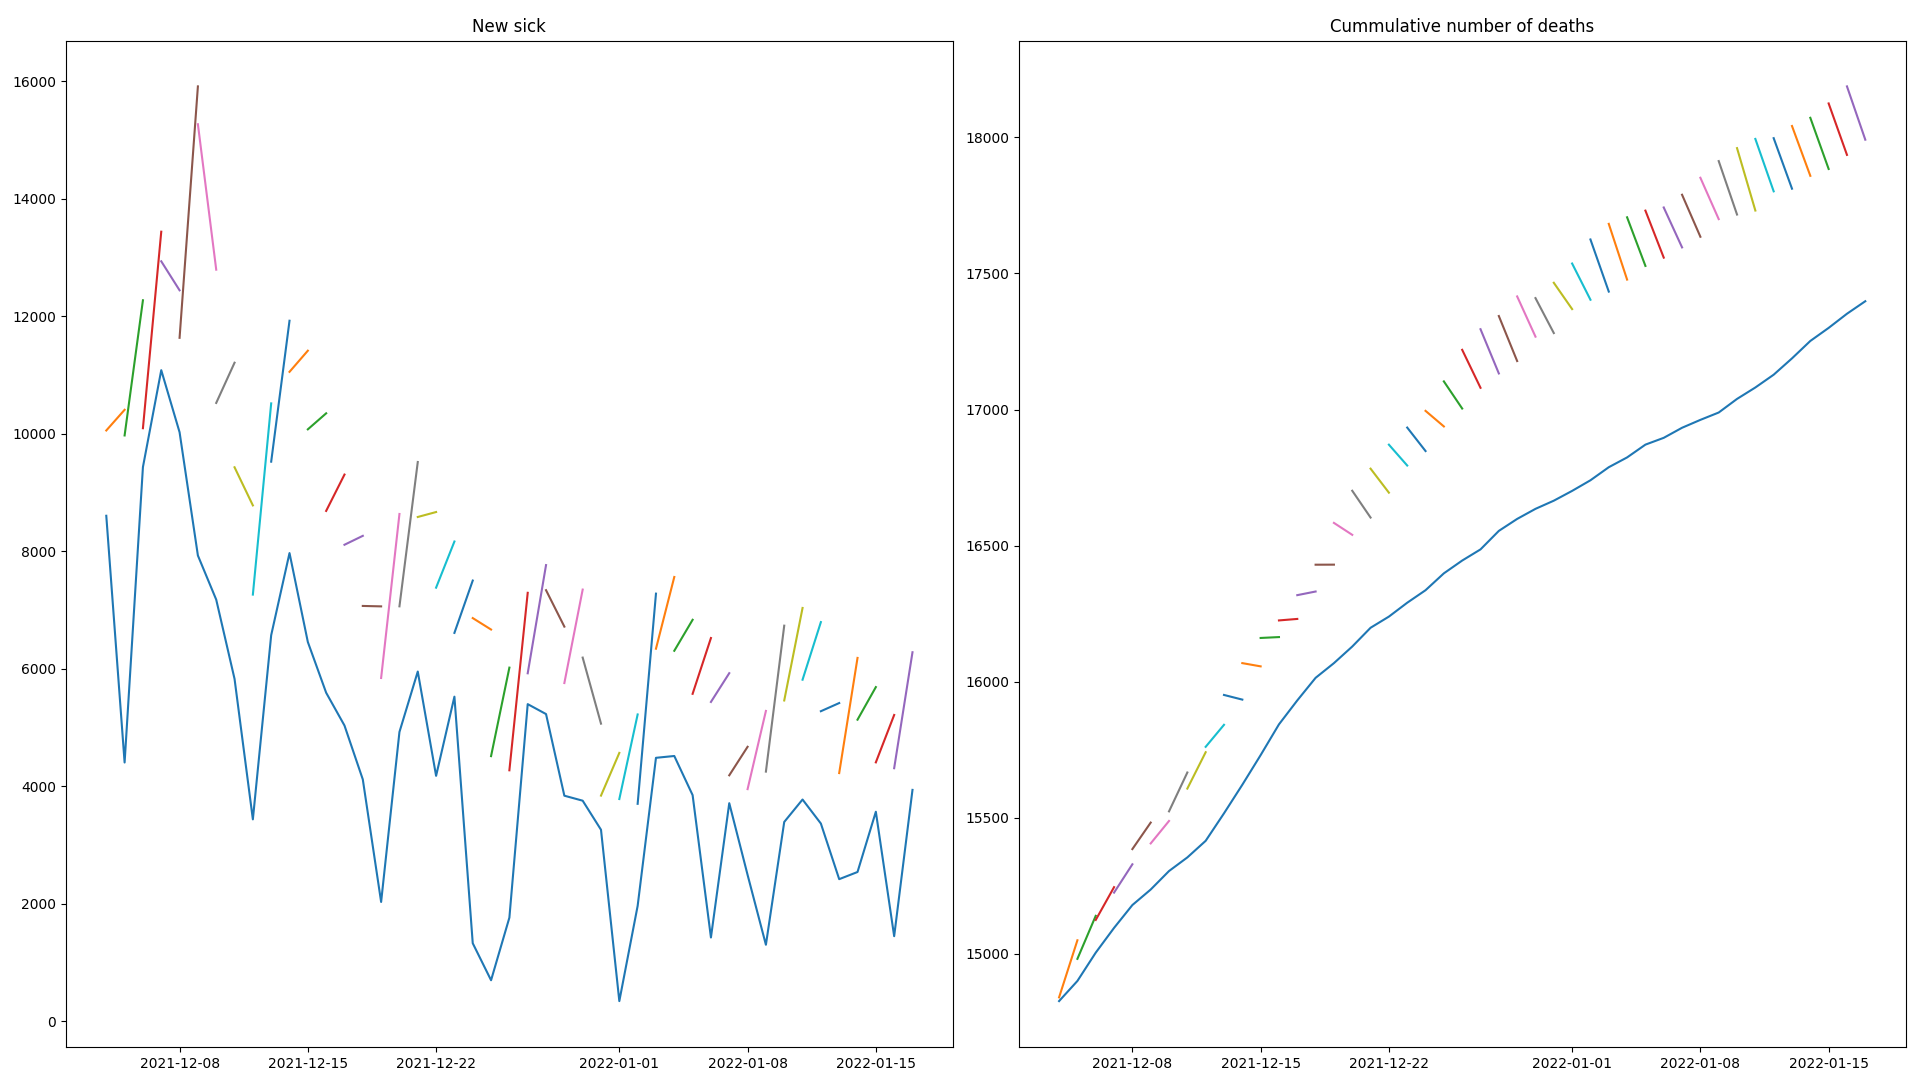

In [6]:
from IPython.display import Image
Image(filename='slovak_combined.png')

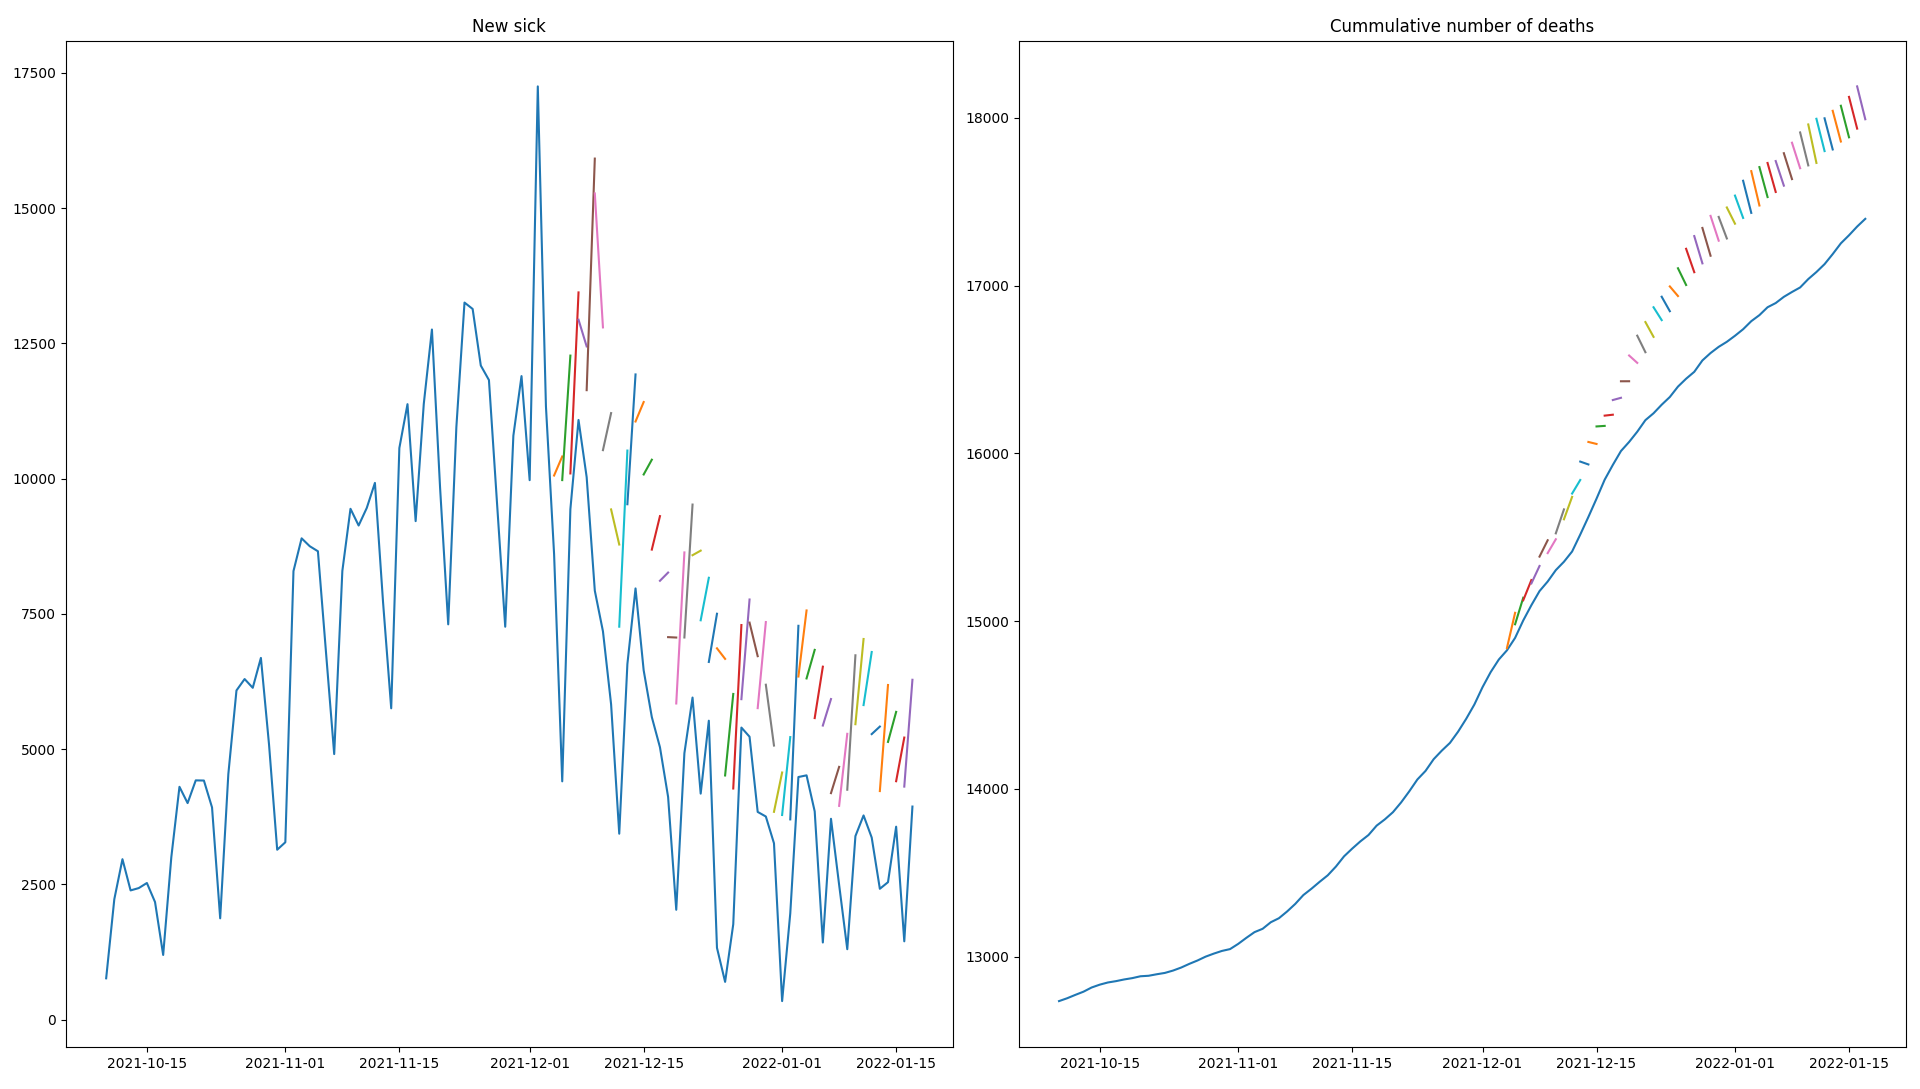

In [7]:
from IPython.display import Image
Image(filename='slovak_complete2.png')

## Possible future work

- better data (from statistical view)
- more data (combine multiple countries)
- use of deep learning and/or other more advanced techniques

### Similar work

Nonlinear Neural Network Based Forecasting Model for Predicting COVID-19 Cases (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8012519/)